In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from abc import ABC, abstractmethod

In [98]:
import cv2
import math
import numpy as np

def edge_detection(frame):
    # Convert the frame to grayscale for edge detection 
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 
      
    # Apply Gaussian blur to reduce noise and smoothen edges 
    blurred = cv2.GaussianBlur(src=gray, ksize=(3, 5), sigmaX=0.5) 
      
    # Perform Canny edge detection 
    edges = cv2.Canny(blurred, 70, 135) 
      
    return blurred, edges

class LinearBoundary(nn.Module):
    def __init__(self, num_r = 100, num_t = 100, resolution = (128,128)):
        super().__init__()
        W, H = resolution
        self.edge_convolution = nn.Conv2d(3, 1, 5 ,1, 2)
        """construct the parameter space to perform search of parameters"""
        dr = math.sqrt(W**2 + H**2) / num_r
        dt = math.pi / num_t
        self.dr, self.dt = dr, dt
        """construct the parameter space to perform search of parameters"""
        self.quantized_r = np.linspace(0, math.sqrt(W**2+H**2), num_r)
        self.quantized_t = np.linspace(0, math.pi, num_t)
        self.quantized_parameters = np.meshgrid(self.quantized_r, self.quantized_t)

    def forward(self, x):
        x = self.edge_convolution(x)
        print(self.quantized_parameters[0].shape)
        print(self.quantized_parameters[1].shape)
        return x

def boundary_restriction(self):
    return

In [7]:
from datasets.plagueworks_dataset import PlagueWorksDataset, DataLoader
resolution = (128, 128)
dataset = PlagueWorksDataset(split = "train", resolution = resolution, dataset_dir = "/Users/melkor/Documents/datasets")
def resample():
    loader = DataLoader(dataset, batch_size = 1, shuffle = True)
    for sample in loader:break
    return sample

In [32]:
import matplotlib.pyplot as plt
import torchvision
def visualize_image_grid(images, row, save_name = "image_grid"):
    plt.figure(save_name, frameon = False, figsize = (10,10));plt.cla()
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    comps_grid = torchvision.utils.make_grid(images,normalize=True,nrow=row).permute([1,2,0])

    plt.imshow(comps_grid.cpu().detach().numpy())
    plt.savefig("outputs/{}.png".format(save_name), bbox_inches='tight', pad_inches=0)

In [35]:
from torchvision.models.optical_flow import raft_large, Raft_Large_Weights
from torchvision.utils import flow_to_image
import torchvision.transforms as T

def preprocess(batch):
    transforms = T.Compose(
        [
            T.ConvertImageDtype(torch.float32),
            T.Normalize(mean=0.5, std=0.5),  # map [0, 1] into [-1, 1],
        ]
    )
    batch = transforms(batch)
    return batch

flow_predicter = raft_large(weights=Raft_Large_Weights.DEFAULT, progress=False)
flow_predicter = flow_predicter.eval()

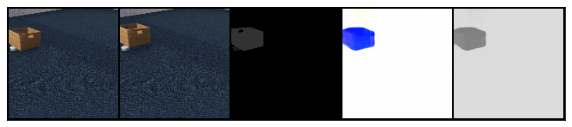

In [115]:
sample = resample()
img1 = sample["img1"]
img2 = sample["img2"]
mask = sample["masks"].unsqueeze(1).repeat(1,3,1,1) * 25.
list_of_flows = flow_predicter(
                preprocess(img1),
                preprocess(img2))
predicted_flows = list_of_flows[-1]
predicted_flows = flow_to_image(predicted_flows)
motion_strength = torch.norm(predicted_flows.permute(0,2,3,1).float() , dim = -1).unsqueeze(1).repeat(1,3,1,1) / 2.0

visualize_image_grid(
    torch.cat([img1 * 255., img2 * 255., mask, predicted_flows, motion_strength], dim = 0),
    row = 5)

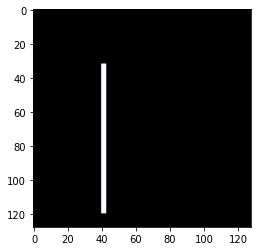

In [122]:
x = torch.zeros([1, 128, 128])
x[:, 32: 120, 40:43] = 1
plt.imshow(x[0].detach(), cmap = "bone")